# 1. VGG16 모델

VGG16 모델의 Image Classification task에서 자주 사용하는 대표적인 모델입니다.

논문: Very Deep Convolutional Networks for Large-Scale Image Recognition

https://arxiv.org/pdf/1409.1556.pdf

VGG16 모델의 구조를 아래 이미지를 통해 꼼꼼히 살펴 보세요.

<img src="https://drive.google.com/uc?id=1v9dbmFOt24OcOJ4woRsudEFnBhIDFOC_">



# 2. 코드 살펴보기

VGG16 모델의 구조를 파악하셨나요? 파악한 VGG16 모델을 코드로 구현해 보는 것이 첫 번째 프로젝트입니다. 프로젝트는 크게 2개의 문제로 구성되어 있습니다.

문제 1-1. VGG16 모델 구현하기
영상의 내용을 참고하여 직접 코드로 모델을 구현해 보세요. Batch Normalization, Parameter Initialization 등을 사용할 수도 있습니다.

문제 1-2. 다양한 방법을 사용하여 모델의 성능 올리기
skip connection, pre-trained model 등 다양한 방법을 사용하여 기본적인 VGG16 모델의 성능보다 높은 정확도를 구해보세요.

먼저 필요한 라이브러리를 불러옵니다.

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt

데이터를 준비합니다. 불러온 데이터는 캐글에서 제공되는 개와 고양이의 데이터로, 이번 프로젝트에서 우리는 개와 고양이를 분류할 예정입니다. test 데이터에서 1은 개, 0은 고양이를 의미합니다.

여러분들이 원하는 이미지 데이터를 불러 Classification을 해보는 것도 좋을 것 같군요. 😊

In [ ]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'

path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)

path = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

68606236/68606236 [==============================] - 1s 0us/step


train 데이터와 validation 데이터에서 개와 고양이 이미지가 저장된 경로를 각각 변수에 저장해 둡니다.

In [ ]:
train_dir = os.path.join(path, 'train')
validation_dir = os.path.join(path, 'validation')
print(train_dir)
print(validation_dir)

/root/.keras/datasets/cats_and_dogs_filtered/train
/root/.keras/datasets/cats_and_dogs_filtered/validation


In [ ]:
# directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')
print(train_cats_dir)

# directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')
print(train_dogs_dir)

# directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')
print(validation_cats_dir)

# directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')
print(validation_dogs_dir)

/root/.keras/datasets/cats_and_dogs_filtered/train/cats
/root/.keras/datasets/cats_and_dogs_filtered/train/dogs
/root/.keras/datasets/cats_and_dogs_filtered/validation/cats
/root/.keras/datasets/cats_and_dogs_filtered/validation/dogs


train 데이터와 validation 데이터의 개수를 알아봅시다.

In [ ]:
num_cats_tr = len(os.listdir(train_cats_dir))
print('total training cat images:', num_cats_tr)
num_dogs_tr = len(os.listdir(train_dogs_dir))
print('total training dog images:', num_dogs_tr)

print("--")

num_cats_val = len(os.listdir(validation_cats_dir))
print('total validation cat images:', num_cats_val)
num_dogs_val = len(os.listdir(validation_dogs_dir))
print('total validation dog images:', num_dogs_val)

print("--")

total_train = num_cats_tr + num_dogs_tr
print("Total training images:", total_train)
total_val = num_cats_val + num_dogs_val
print("Total validation images:", total_val)

total training cat images: 1000
total training dog images: 1000
--
total validation cat images: 500
total validation dog images: 500
--
Total training images: 2000
Total validation images: 1000


필요한 파라미터를 설정해 줍시다. 파라미터를 수정하면 성능을 높일 수 있으니 다양한 실험을 해보세요.

In [ ]:
# parameter Initialization
batch_size = 16
epochs = 5
IMG_HEIGHT = 256
IMG_WIDTH = 256

이미지를 확인하기 위해 데이터를 시각화하는 함수를 만들어 봅시다. 간단한 함수이기 때문에 자세한 코드 설명은 생략하겠습니다. 궁금하다면 구글링을 통해 각 코드가 어떤 역할을 하는지 찾아보세요.

In [ ]:
# 데이터를 시각화하기 위한 함수
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(10,10))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

train 데이터가 2천장 밖에 되지 않기 때문에 Data Augmentation(데이터 증강)을 통해 데이터의 수를 늘립니다.

Data Augmentation은 Rescale, Rotation, Random Crop, Zoom, Flip 등 다양한 기법을 사용하여 데이터의 양을 증가시키는 것입니다. range의 숫자를 변화시키거나 Flip에서 True/False를 적절하게 사용하여 다양한 실험을 해보세요.

In [ ]:
# Training data generator
image_gen_train = ImageDataGenerator(rescale=1./255,
                                     rotation_range=0.3,
                                     width_shift_range=0.1,
                                     height_shift_range=0.1,
                                     zoom_range=0.2,
                                     horizontal_flip=True,
                                     vertical_flip=False)

.flow_from_directory를 사용하여 파이프라인을 만들어 directory와 작업 환경을 연결시켜 줍니다. 우리는 개와 고양이를 분류하는 task를 수행하기 때문에class_mode는 'binary'입니다. Classification task에 따라 class_mode를 변경하시면 됩니다.

In [ ]:
train_data_gen = image_gen_train.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')

Found 2000 images belonging to 2 classes.


Data Augmentation이 제대로 되었는지 확인해 봅시다.

In [ ]:
train_data_gen[0][0].shape

(16, 256, 256, 3)

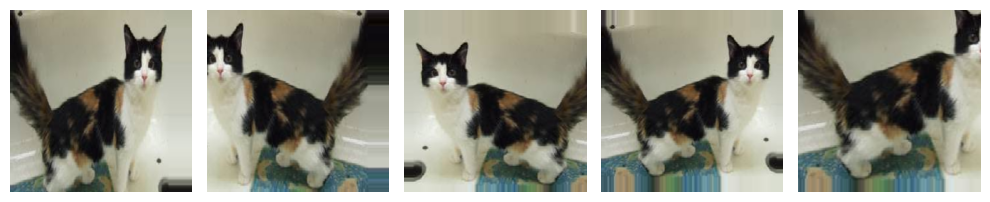

In [ ]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

Validation 데이터에도 train 데이터와 같은 동일한 작업을 해 줍니다. 그러나 Validation 데이터는 classification이 잘 되는지 평가하는 용도로 사용되기 때문에 데이터의 스케일만 변경해 줍니다.

In [ ]:
# Validation data generator
image_gen_val = ImageDataGenerator(rescale=1./255)

In [ ]:
val_data_gen = image_gen_val.flow_from_directory(batch_size=batch_size,
                                                 directory=validation_dir,
                                                 target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                 class_mode='binary')

Found 1000 images belonging to 2 classes.


Validation 데이터를 확인해 봅시다. 크게 이미지와 정답 데이터로 구성이 되어 있습니다.

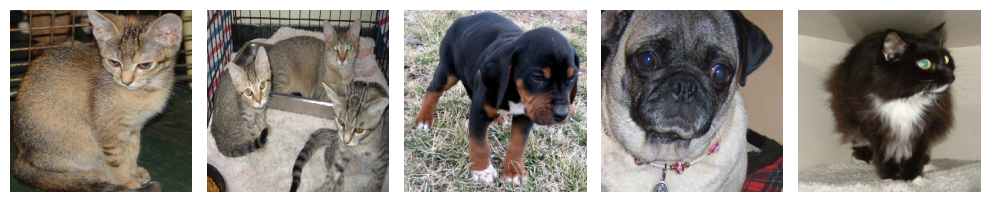

In [ ]:
sample_training_images, _ = next(val_data_gen)
plotImages(sample_training_images[:5])

In [ ]:
_[:5] # 정답 데이터

array([0., 0., 1., 1., 0.], dtype=float32)

## 문제 1-1. VGG16 모델 구현하기

이제 VGG16 모델을 구현해 볼 시간입니다. 바로 혼자서 모델을 구현하라고 하면 어렵겠죠? 그래서 참고할만한 모델 구현 코드를 아래에 적어 보았습니다. 실제 VGG16 모델과는 살짝 구조가 다르기 때문에 이미지를 보면서 어느 부분이 다른치 찾아 보는 것도 좋을 것 같습니다.

# 참고 코드

input_layer=tf.keras.layers.Input(shape=(256, 256, 3))

x=tf.keras.layers.Conv2D(32, (3, 3), strides=1, activation='relu',
padding='same')(input_layer)

x=tf.keras.layers.Conv2D(32, (3, 3), strides=1, activation='relu', padding='same')(x)

x=tf.keras.layers.BatchNormalization()(x)

x=tf.keras.layers.MaxPool2D((2, 2))(x)

x=tf.keras.layers.Conv2D(64, (3, 3), strides=1, activation='relu', padding='same')(x)

x=tf.keras.layers.Conv2D(64, (3, 3), strides=1, activation='relu',
padding='same')(x)

x=tf.keras.layers.BatchNormalization()(x)

x=tf.keras.layers.MaxPool2D((2, 2))(x)

x=tf.keras.layers.Conv2D(128, (3, 3), strides=1, activation='relu',
padding='same')(x)

x=tf.keras.layers.Conv2D(128, (3, 3), strides=1, activation='relu',
padding='same')(x)

x=tf.keras.layers.BatchNormalization()(x)

x=tf.keras.layers.MaxPool2D((2, 2))(x)

x=tf.keras.layers.Flatten()(x)

x=tf.keras.layers.Dense(1024, activation='relu')(x)

x=tf.keras.layers.Dense(512, activation='relu')(x)

out_layer=tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs=[input_layer], outputs=[out_layer])

model.summary()

VGG16 모델의 구조를 다시 상기해 보고, 위의 코드를 참고하여 VGG16 모델을 직접 구현해 보세요.

아래 이미지와 동일하게 VGG16 모델을 구현하려면 GPU 크키가 더 커야할 수도 있습니다. 구현한 모델을 학습시키다가 커널이 죽을 경우에는 모델 사이즈를 작게 수정해 보세요.


<img src="https://drive.google.com/uc?id=1CshcuYjehWvYlZPfc8L7fg1hjjtHBAYG">

In [ ]:
# 문제1-1. 이미지에 나온 VGG16 모델을 구현하세요.
input_layer=tf.keras.layers.Input(shape=(256, 256, 3))

x=tf.keras.layers.Conv2D(32, (3, 3), strides=1, activation='relu',
padding='same')(input_layer)

x=tf.keras.layers.Conv2D(32, (3, 3), strides=1, activation='relu', padding='same')(x)

x=tf.keras.layers.BatchNormalization()(x)

x=tf.keras.layers.MaxPool2D((2, 2))(x)

x=tf.keras.layers.Conv2D(64, (3, 3), strides=1, activation='relu', padding='same')(x)

x=tf.keras.layers.Conv2D(64, (3, 3), strides=1, activation='relu',
padding='same')(x)

x=tf.keras.layers.BatchNormalization()(x)

x=tf.keras.layers.MaxPool2D((2, 2))(x)

x=tf.keras.layers.Conv2D(128, (3, 3), strides=1, activation='relu',
padding='same')(x)

x=tf.keras.layers.Conv2D(128, (3, 3), strides=1, activation='relu',
padding='same')(x)

x=tf.keras.layers.BatchNormalization()(x)

x=tf.keras.layers.MaxPool2D((2, 2))(x)

x=tf.keras.layers.Flatten()(x)

x=tf.keras.layers.Dense(1024, activation='relu')(x)

x=tf.keras.layers.Dense(512, activation='relu')(x)

out_layer=tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs=[input_layer], outputs=[out_layer])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 32)      9248      
                                                                 
 batch_normalization (Batch  (None, 256, 256, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 128, 128, 32)      0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 64)      18496 

손실함수, optimizer, metric을 설정해 줍니다.

손실함수와 metric은 분류 task에 따라 다양하게 바꿀 수 있습니다. optimizer도 Adam 외에 다양한 것을 사용할 수 있습니다. 자유롭게 바꿔보세요.

In [ ]:
loss_function=tf.keras.losses.binary_crossentropy
optimize=tf.keras.optimizers.Adam(learning_rate=0.01)
metric=tf.keras.metrics.binary_accuracy
model.compile(loss=loss_function,
              optimizer=optimize,
              metrics=[metric])

# callbacks_list= [tf.keras.callbacks.TensorBoard(log_dir='log_dir', histogram_freq=1)]
# callback 함수를 활용하고 싶다면 추가해서 학습하는 데에 활용해 보세요.

모델 학습을 시켜봅시다.
data generator는 입력 데이터와 타겟(라벨)의 batch를 끝없이 반환합니다.
batch가 끝없이 생성되기 때문에, 한 번의 epoch에 generator로부터 얼마나 많은 샘플을 뽑을지 모델에 전달해야 합니다.
만약 batch_size=20이고 steps_per_epoch=100일 경우 (데이터, 라벨)의 쌍 20개가 생성되고, 크기가 20인 batch 데이터를 100번 학습하면 1 epoch이 완료됩니다. 단, 크기 20의 batch 데이터는 매번 랜덤으로 생성됩니다.

일반적으로 (전체 데이터 길이/batch_size)를 steps_per_epoch으로 설정합니다.






In [22]:
history = model.fit(
      train_data_gen,
      steps_per_epoch=(len(os.listdir(train_cats_dir)) + len(os.listdir(train_dogs_dir)))/batch_size,
      epochs=epochs,
      validation_data=val_data_gen,
      # callbacks=callbacks_list,
      validation_freq=1)

Epoch 1/5
125/125 [==============================] - 1464s 12s/step - loss: 37.5700 - binary_accuracy: 0.5080 - val_loss: 0.6964 - val_binary_accuracy: 0.5000
Epoch 2/5
125/125 [==============================] - 1448s 12s/step - loss: 0.6994 - binary_accuracy: 0.5080 - val_loss: 0.6938 - val_binary_accuracy: 0.5100
Epoch 3/5
125/125 [==============================] - 1523s 12s/step - loss: 0.6956 - binary_accuracy: 0.4975 - val_loss: 0.6896 - val_binary_accuracy: 0.5140
Epoch 4/5
125/125 [==============================] - 1493s 12s/step - loss: 0.6948 - binary_accuracy: 0.5015 - val_loss: 0.6938 - val_binary_accuracy: 0.4970
Epoch 5/5
125/125 [==============================] - 1494s 12s/step - loss: 0.6937 - binary_accuracy: 0.5000 - val_loss: 0.6971 - val_binary_accuracy: 0.4990


학습이 되었다면 시각화를 통해 정확도를 알아봅시다.

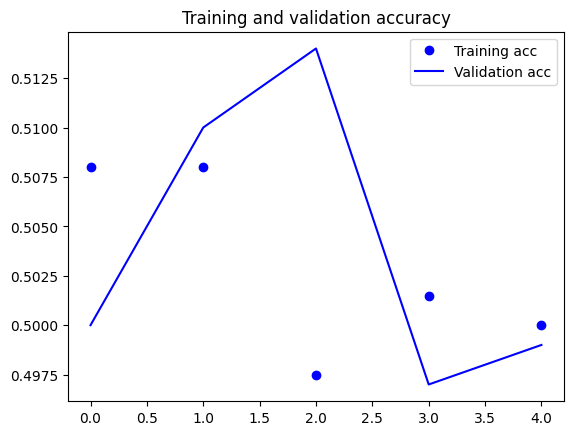

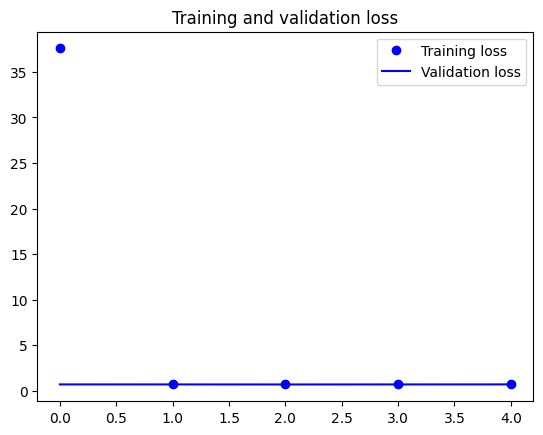

In [23]:
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.plot(epochs_range, acc, 'bo', label='Training acc')
plt.plot(epochs_range, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs_range, loss, 'bo', label='Training loss')
plt.plot(epochs_range, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

성능이 그리 좋지는 않습니다.

## 문제 1-2. 다양한 방법을 사용하여 모델의 성능 올리기

hyperparameter 변경, 모델 수정, optimizer 변경, skip connection, pre-trained model 등 다양한 방법을 사용하면 모델의 성능을 높일 수 있습니다. 다양한 실험을 통해 성능을 올려 보세요.

In [ ]:
# 문제 1-2. hyperparameter 설정
# [[YOUR CODE]]

In [ ]:
# 문제 1-2. 데이터 generator 생성
# [[YOUR CODE]]

In [ ]:
# 문제 1-2. 모델 구현
# [[YOUR CODE]]

In [ ]:
# 문제 1-2. loss function, optimizer, metric 설정 및 모델 컴파일
# [[YOUR CODE]]

In [ ]:
# 모델 학습
history = model.fit(
      train_data_gen,
      steps_per_epoch=(len(os.listdir(train_cats_dir)) + len(os.listdir(train_dogs_dir)))/batch_size,
      epochs=epochs,
      validation_data=val_data_gen,
      # callbacks=callbacks_list,
      validation_freq=1)

In [ ]:
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.plot(epochs_range, acc, 'bo', label='Training acc')
plt.plot(epochs_range, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs_range, loss, 'bo', label='Training loss')
plt.plot(epochs_range, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()